# Evaluate MENT model

In [7]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import proplot as pplt
import psdist as ps
import psdist.visualization as psv
import scipy.ndimage
import torch
import zuko
from ipywidgets import interact
from ipywidgets import widgets

import mentflow as mf
from mentflow.utils import grab
from mentflow.utils import unravel

from experiments.load import load_ment_run
from setup import make_dist

In [8]:
mf.train.plot.set_proplot_rc()

## Settings

In [9]:
device = "cpu"
precision = torch.float32

def send(x):
    return x.type(precision).to(device)

## Load data

In [10]:
script_name = "train_ment"
timestamp = 240128211353
data_dir = f"./outputs/{script_name}/{timestamp}/"

In [11]:
run = load_ment_run(data_dir, device=device)

cfg = run["config"]
history = run["history"]
model = run["model"]
checkpoints = run["checkpoints"]

In [12]:
dist = make_dist(cfg)

## Scalar history

In [13]:
# keys_sorted = sorted(list(history.keys()))
# imax = len(history[keys_sorted[0]])

# @interact(
#     key=widgets.Dropdown(options=keys_sorted, value="D_norm"),
#     irange=widgets.IntRangeSlider(min=0, max=imax, value=(0, imax)),
#     log=False,
# )
# def update(key, irange, log):
#     vals = history[key]
#     # avgs = mf.utils.exp_avg(vals, momentum=0.95)

#     fig, ax = pplt.subplots()
#     ax.plot(vals[irange[0] : irange[1]], color="gray")
#     ax.plot(avgs[irange[0] : irange[1]], color="black", lw=1.0)    
#     if log:
#         ax.format(yscale="log", yformatter="log")
#     ax.format(xlabel="Iteration (global)", ylabel=key)
#     plt.show()

## Evaluation

### Radial PDF

In [ ]:
@interact(
    index=widgets.IntSlider(
        min=0, 
        max=(len(checkpoints) - 1), 
        value=(len(checkpoints) - 1),
    ),
    n_samples=widgets.FloatLogSlider(min=2, max=6, value=1.00e+05),
    rmax=widgets.FloatSlider(min=0.0, max=6.0, value=3.5),
    bins=widgets.IntSlider(min=4, max=150, value=50),
    kind=["step", "line"],
)
def update(index, n_samples, rmax, bins, kind):
    model.load(checkpoints[index]["path"], device)

    with torch.no_grad():
        n_samples = int(n_samples)
        x1 = grab(dist.sample(n_samples))
        x2 = grab(model.sample(n_samples))

        colors = ["red4", "black"]
        normalize = True
        
        bin_edges = np.linspace(0.0, rmax, bins + 1)
    
        r1 = np.linalg.norm(x1, axis=1)
        r2 = np.linalg.norm(x2, axis=1)
        hist_r1, _ = np.histogram(r1, bins=bin_edges, density=True)
        hist_r2, _ = np.histogram(r2, bins=bin_edges, density=True)
        if normalize:
            for i in range(len(bin_edges) - 1):
                rmin = bin_edges[i]
                rmax = bin_edges[i + 1]
                hist_r1[i] = hist_r1[i] / mf.utils.sphere_shell_volume(rmin=rmin, rmax=rmax, d=x1.shape[1])
                hist_r2[i] = hist_r2[i] / mf.utils.sphere_shell_volume(rmin=rmin, rmax=rmax, d=x2.shape[1])
        
        fig, ax = pplt.subplots(figsize=(3.0, 2.0))
        scale = hist_r1.max()
        psv.plot_profile(hist_r1 / scale, edges=bin_edges, ax=ax, color=colors[0], kind="step", lw=1.5)
        psv.plot_profile(hist_r2 / scale, edges=bin_edges, ax=ax, color=colors[1], kind="step", lw=1.5)
        ax.format(ymax=1.1)

        # for name in ["gaussian", "kv"]:
        #     x = mf.dist.dist_nd.gen_dist(name=name, noise=0.0).sample(n_samples)
        #     x = grab(x)     
        #     r = np.linalg.norm(x, axis=1)
        #     hist, _ = np.histogram(r, bins=bin_edges, density=True)
        #     if normalize:
        #         for i in range(len(bin_edges) - 1):
        #             rmin = bin_edges[i]
        #             rmax = bin_edges[i + 1]
        #             hist[i] = hist[i] / mf.utils.sphere_shell_volume(rmin=rmin, rmax=rmax, d=x.shape[1])
            # psv.plot_profile(hist / scale, edges=bin_edges, ax=ax, color="black", kind="step", lw=1.5, ls="--", alpha=0.15)
        
        r = np.linspace(0.0, rmax, 100)
        ax.plot(r, np.exp(-0.5 * r**2), color="black", alpha=0.1, ls="--", zorder=0, lw=1.5)          
        
        ax.format(xlabel="Radius", ylabel="PDF")
        pplt.show()

### Radial CDF

In [ ]:
@interact(
    index=widgets.IntSlider(
        min=0, 
        max=(len(checkpoints) - 1), 
        value=(len(checkpoints) - 1),
    ),
    n_samples=widgets.FloatLogSlider(min=2, max=6, value=1.00e+05),
    rmax=widgets.FloatSlider(min=0.0, max=6.0, value=3.0),
    bins=widgets.IntSlider(min=4, max=150, value=50),
    kind=["step", "line"],
)
def update(index, n_samples, rmax, bins, kind):
    model.load(checkpoints[index]["path"], device)

    with torch.no_grad():
        n_samples = int(n_samples)
        x1 = grab(dist.sample(n_samples))
        x2 = grab(model.sample(n_samples))
        
        fig, ax = mf.train.plot.plot_dist_radial_cdf(x1, x2, rmax=rmax, bins=bins, kind=kind, lw=1.5, colors=["red4", "black"])

        for name in ["kv", "gaussian"]:
            x = mf.dist.dist_nd.gen_dist(name=name, noise=0.0).sample(n_samples)
            x = grab(x)     
            hist, edges = ps.points.radial_histogram(x, bins=75, limits=(0.0, rmax))
            cdf = np.cumsum(hist)
            cdf = cdf / cdf[-1]
            psv.plot_profile(cdf, edges=edges, ax=ax, kind="line", color="black", alpha=0.1, ls="--", zorder=0, lw=1.5)
        ax.format(xlabel="Radius", ylabel="CDF")
        pplt.show()

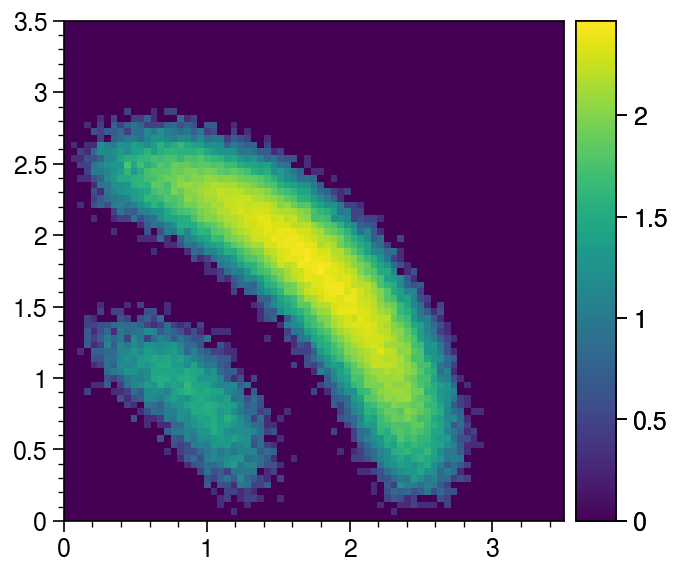

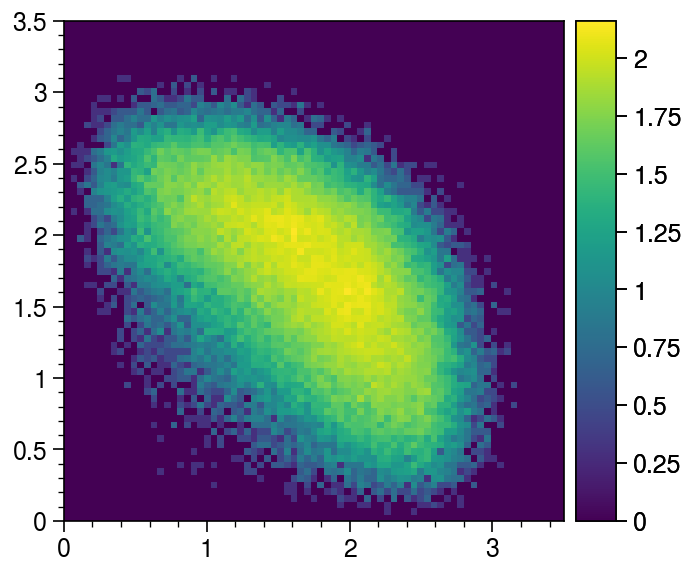

In [17]:
model.load(checkpoints[-1]["path"], device)
with torch.no_grad():
    n_samples = 100000
    n_samples = int(n_samples)
    x1 = grab(dist.sample(n_samples))
    x2 = grab(model.sample(n_samples))

    for x in [x1, x2]:
        r  = np.linalg.norm(x[:, :3], axis=1)
        rp = np.linalg.norm(x[:, 3:], axis=1)
        fig, ax = pplt.subplots()
        hist, edges_x, edges_y = np.histogram2d(r, rp, bins=75, range=(2 * [(0.0, 3.5)]))
        hist = np.ma.log10(hist)
        hist = np.ma.filled(hist, 0.0)
        ax.pcolormesh(edges_x, edges_y, hist.T, colorbar=True, cmap="viridis")

## 2D projections

In [ ]:
@interact(
    dim1=widgets.Dropdown(options=range(cfg.d), value=0),
    dim2=widgets.Dropdown(options=range(cfg.d), value=1),
    index=widgets.IntSlider(
        min=0, 
        max=(len(checkpoints) - 1), 
        value=(len(checkpoints) - 1),
    ),
    n=widgets.FloatLogSlider(min=2.0, max=6.0, value=1.00e+05),
    xmax=widgets.FloatSlider(min=0.0, max=6.0, value=3.0),
    bins=widgets.IntSlider(min=4, max=150, value=85),
)
def update(dim1, dim2, index, n, xmax, bins):
    if dim1 == dim2:
        return
    model.load(checkpoints[index]["path"], device)

    with torch.no_grad():
        x1 = grab(dist.sample(int(n)))
        x2 = grab(model.sample(int(n)))

        fig, axs = pplt.subplots(ncols=2, xspineloc="neither", yspineloc="neither")
        for x, ax in zip([x1, x2], axs):
            psv.points.plot2d(
                x[:, (dim1, dim2)],
                bins=bins,
                limits=(2 * [(-xmax, xmax)]),
                ax=ax,
                mask=False,
            )
        pplt.show()

### Corner plot

In [ ]:
@interact(
    index=widgets.IntSlider(
        min=0,
        max=(len(checkpoints) - 1),
        value=(len(checkpoints) - 1),
    ),
    n=widgets.FloatLogSlider(min=2, max=6, value=1.00e+05, continuous_update=False),
    xmax=widgets.FloatSlider(min=0.0, max=6.0, value=3.0),
    bins=widgets.IntSlider(min=4, max=150, value=85),
)
def update(index, n, xmax, bins):
    model.load(checkpoints[index]["path"], device)

    with torch.no_grad():
        x1 = grab(dist.sample(int(n)))
        x2 = grab(model.sample(int(n)))

        mask = True

        grid = psv.CornerGrid(d=x1.shape[1], corner=False)
        limits = [(-xmax, xmax)] * x1.shape[1]
        grid.plot_points(
            x2,
            lower=True,
            upper=False,
            mask=mask,
            bins=bins,
            limits=limits,
            cmap="blues",
            diag_kws=dict(color="blue7", lw=1.5),
        )
        grid.plot_points(
            x1,
            upper=True,
            lower=False,
            mask=mask,
            bins=bins,
            limits=limits,
            cmap="reds",
            diag_kws=dict(color="red7", lw=1.5),
        )
        pplt.show()

In [ ]:
@interact(
    index=widgets.IntSlider(
        min=0,
        max=(len(checkpoints) - 1),
        value=(len(checkpoints) - 1),
    ),
    n=widgets.FloatLogSlider(min=2, max=6, value=1.00e+05, continuous_update=False),
    xmax=widgets.FloatSlider(min=0.0, max=6.0, value=3.0),
    bins=widgets.IntSlider(min=4, max=150, value=85),
)
def update(index, n, xmax, bins):
    model.load(checkpoints[index]["path"], device)

    with torch.no_grad():
        x1 = grab(dist.sample(int(n)))
        x2 = grab(model.sample(int(n)))

        mask = True

        grid = psv.CornerGrid(d=x1.shape[1], corner=False)
        limits = [(-xmax, xmax)] * x1.shape[1]
        grid.plot_points(
            x2,
            lower=True,
            upper=False,
            mask=mask,
            bins=bins,
            limits=limits,
            cmap="blues",
            diag_kws=dict(color="blue7", lw=1.5),
        )
        grid.plot_points(
            x1,
            upper=True,
            lower=False,
            mask=mask,
            bins=bins,
            limits=limits,
            cmap="reds",
            diag_kws=dict(color="red7", lw=1.5),
        )

        # Try to identify measurement boundary.
        for transform in model.transforms:
            direction = transform.direction
            x = torch.zeros((500, cfg.d))
            amplitudes = torch.linspace(-xmax, xmax, x.shape[0]) * 5.0
            for i in range(x.shape[0]):
                x[i] = amplitudes[i] * direction
            x = grab(x)

            grid.plot_points(x, kind="scatter", diag=False, s=0.5, update_limits=False)
                
        pplt.show()

### Simulated measurements

In [ ]:
# @interact(
#     index=widgets.IntSlider(
#         min=0, 
#         max=(len(checkpoints) - 1), 
#         value=(len(checkpoints) - 1),
#     ),
#     n=widgets.FloatLogSlider(min=2, max=6, value=50000),
#     log_ymin=widgets.FloatSlider(min=-5.0, max=-1.0, value=-3.0),
# )
# def update(index, n, log_ymin, kde=False, log=False):
#     model.load(checkpoints[index]["path"], device=device)

#     with torch.no_grad():
#         x = send(model.sample(int(n)))

#         for diagnostic in unravel(model.diagnostics):
#             diagnostic.kde = kde
            
#         predictions = mf.sim.forward(x, model.transforms, model.diagnostics)

#         fig, axs = mf.train.plot.plot_proj_1d(
#             [grab(measurement) for measurement in unravel(model.measurements)][:5],
#             [grab(prediction) for prediction in unravel(predictions)][:5],
#             [grab(diagnostic.bin_edges) for diagnostic in unravel(model.diagnostics)][:5],
#             maxcols=7,
#             kind="line",
#             height=1.25,
#             lw=1.5,
#         )
#         axs.format(ymax=1.25, ymin=(10.0 ** log_ymin))
#         if log:
#             axs.format(yscale="log")
#         plt.show()

In [ ]:
# @interact(
#     index=widgets.IntSlider(
#         min=0, 
#         max=(len(checkpoints) - 1), 
#         value=(len(checkpoints) - 1),
#     ),
#     n=widgets.FloatLogSlider(min=2, max=6, value=50000),
#     log_ymin=widgets.FloatSlider(min=-5.0, max=-1.0, value=-3.0),
# )
# def update(index, n, log_ymin, kde=False, log=False):
#     model.load(checkpoints[index]["path"], device=device)

#     with torch.no_grad():
#         x = send(model.sample(int(n)))

#         for diagnostic in unravel(model.diagnostics):
#             diagnostic.kde = kde
            
#         predictions = mf.sim.forward(x, model.transforms, model.diagnostics)

#         y_meas = [grab(meas) for meas in unravel(model.measurements)]
#         y_pred = [grab(pred) for pred in unravel(predictions)]
#         bin_edges = [grab(diagnostic.bin_edges) for diagnostic in unravel(model.diagnostics)]

#         maxcols = 10
#         ncols = min(len(y_meas), maxcols)
#         nrows = int(np.ceil(len(y_meas) / ncols))    
#         figheight = 0.50 * nrows
#         figwidth = 0.80 * ncols
#         fig, axs = pplt.subplots(
#             ncols=ncols, nrows=nrows, figheight=figheight, figwidth=figwidth, space=0.0, xticks=[], yticks=[]
#         )
#         for i in range(len(y_meas)):
#             scale = np.max(y_meas[i])
#             psv.plot_profile(y_meas[i] / scale, edges=bin_edges[i], ax=axs[i], lw=1.5, color="red4")
#             psv.plot_profile(y_pred[i] / scale, edges=bin_edges[i], ax=axs[i], lw=1.5, color="black")
    
#         axs.format(ymax=1.25, ymin=(10.0 ** log_ymin))
#         if log:
#             axs.format(yscale="log")
#         plt.show()

### Grid warp 

In [ ]:
@interact(
    index=widgets.IntSlider(
        min=0, 
        max=(len(checkpoints) - 1), 
        value=(len(checkpoints) - 1),
    ),
    xmax=widgets.FloatSlider(min=0.0, max=6.0, value=3.0),
    n_lines=widgets.IntSlider(min=0.0, max=200, value=100),
)
def update(index, xmax, n_lines):
    model.load(checkpoints[index]["path"], device=device)

    with torch.no_grad():
        fig, axs = pplt.subplots(ncols=2)

        res = 150
        grid = np.linspace(-3.5 * xmax, 3.5 * xmax, n_lines)
        line_points = []
        for i in range(len(grid)):
            x = np.full(res, grid[i])
            y = np.linspace(-xmax, xmax, res)
            line_points.append(np.vstack([x, y]).T)
            line_points.append(np.vstack([y, x]).T)
        
        kws = dict(color="black", lw=0.6, alpha=0.25)
        
        for z in line_points:
            axs[0].plot(z[:, 0], z[:, 1], **kws)
            z = np.hstack([z, np.zeros((z.shape[0], cfg.d - z.shape[1]))])
            z = send(torch.from_numpy(z))
            x = grab(model.gen.forward(z))
            for ax in axs[1:]:
                ax.plot(x[:, 0], x[:, 1], **kws)
        
        z = model.gen.sample_base(1000)
        x = model.gen.forward(z)
        z = grab(z)
        x = grab(x)
        kws = dict(c="black", zorder=999, s=1)
        axs[0].scatter(z[:, 0], z[:, 1], **kws)
        axs[1].scatter(x[:, 0], x[:, 1], **kws)
        axs.format(xlim=(-xmax, xmax), ylim=(-xmax, xmax))
        plt.show()

### Flow trajectory

In [ ]:
@interact(
    index=widgets.IntSlider(
        min=0, 
        max=(len(checkpoints) - 1), 
        value=(len(checkpoints) - 1),
    ),
    n=widgets.FloatLogSlider(min=2, max=6, value=1.00e+05),
    xmax=widgets.FloatSlider(min=0.0, max=6.0, value=3.0),
    bins=widgets.IntSlider(min=4, max=150, value=75),
)
def update(index, n, xmax, bins):        
    model.load(checkpoints[index]["path"], device)

    with torch.no_grad():
        z = model.gen.sample_base(int(n))
        
        try:
            xt = model.gen.forward_steps(z)
        except:
            print("`model.gen` does not have `forward_steps` method.")
    
        fig, axs = pplt.subplots(
            figheight=2.0, 
            ncols=len(xt), 
            space=None,
            xticks=[],
            yticks=[], 
            xspineloc="neither",
            yspineloc="neither",
        )
        limits = 2 * [(-xmax, xmax)]
        for ax, x in zip(axs, xt):
            x = grab(x)
            ax.hist2d(x[:, 0], x[:, 1], bins=bins, range=limits)
        axs.format(xlim=limits[0], ylim=limits[1])
        plt.show()